# Plotting the Gadget Simulation results


In [1]:
%matplotlib inline

from __future__ import division

from pygadgetreader import *

import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
from tqdm import tqdm
import sys

#----- MATPLOTLIB paramaters ---------
mpl.rcParams.update({'font.size': 18,'font.family':'serif'})

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.right'] = True
mpl.rc('text', usetex=True)
#--------------------------------------

from scipy.interpolate import interp1d
from scipy.integrate import quad


#### Some constants and parameters

You should specify the name of the simulation with `simID`, as well as the total number of snapshots - this varies between simulations, so you should check the 'out/' folder of each simulation to check. You might also want to change the title text if you're interested in pretty plots.

Note that this code probably won't work with the 'high-resolution' simulations. That compatibility will be added later...


In [4]:
G_N = 4.302e-3 #(pc/solar mass) (km/s)^2

simID = "M30_a0.01_lo_bin_e0.995_full"

title_text = r"$M_\mathrm{PBH} = 30\,\,M_\odot$, $a_i = 0.01\,\,\mathrm{pc}$, $e_i = 0.995$"

Nframes = 2001

rootdir = "sims/" + simID + "/out/"

print "Loading output from folder: ", rootdir

M_PBH =readsnap(rootdir+"snapshot_000", "mass", 1, suppress=1)[0]

Loading output from folder:  sims/M30_a0.01_lo_bin_e0.995_full/out/


In [5]:
#Read in the first header file
part_string = ["dmcount", "diskcount","bulgecount", "starcount","bndrycount"]

nParticles = np.zeros(5, dtype='int')
for i in range(5):
    nParticles[i] = readheader(rootdir+"snapshot_000", part_string[i])

nPBH = nParticles[0]
nDM = nParticles[1:]
print "   Number of PBHs:", nPBH
print "   Number of DM particles:", nDM

mDM = np.zeros(4)
for i in range(4):
    #print nDM[i]
    if (nDM[i] > 0):
        #print readsnap(rootdir+"snapshot_000", "mass", i+2, suppress=1)[0]
        mDM[i] = readsnap(rootdir+"snapshot_000", "mass", i+2, suppress=1)[0]

print "   DM particle masses:", mDM

r_tr = 1.0
aPBH = 1.0

scaling = 1e-5


   Number of PBHs: 2
   Number of DM particles: [18080     0     0     0]
   DM particle masses: [ 0.00034321  0.          0.          0.        ]


#### Functions for reading in and calculating simulation properties

In [6]:
def GetPBHsep(i):
    id = format(i, '03d')
    xPBH = readsnap(rootdir+"snapshot_" + str(id), "pos", 1, suppress=1)
    deltax = xPBH[0,:] - xPBH[1,:]
    return scaling*np.sqrt(np.sum(deltax**2))

def GetDMr(i):
    id = format(i, '03d')
    #print "   Snapshot", id
    xPBH = readsnap(rootdir+"snapshot_" + str(id), "pos", 1, suppress=1)
    #xPBH = 0.0
    pid = readsnap(rootdir+"snapshot_" + str(id), "pid", 1, suppress=1)
    
    i1 = [0,1]
    if (pid[0] > pid[1]):
        i1 = [1,0]

    if (nPBH > 1):
        xPBH = 1.0*xPBH[i1[0],:]
    xDM = readsnap(rootdir+"snapshot_" + str(id), "pos", 2, suppress=1)
    rDM = np.sqrt(np.sum((xDM - xPBH)**2.0, axis=1))
    #print np.min(rDM*scaling)
    return scaling*rDM

#DM mass inside 0.1 r_tr (for 30 M_solar)
def GetDMenc(fid):
    return mDM[0]*np.sum(GetDMr(fid) < 4.33e-04)

def GetL_PBH(fid):
    id = format(fid, '03d')
    xPBH = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 1, suppress=1)
    #print xPBH
    vPBH = readsnap(rootdir+"snapshot_" + str(id), "vel", 1, suppress=1)
    #print vPBH
    L_PBH = np.cross(xPBH, vPBH)
    #print L_PBH
    return M_PBH*np.sum(L_PBH, axis=0)
    #return M_PBH*L_PBH[0,:]

def Getv_PBH(fid):
    id = format(fid, '03d')
    vPBH = readsnap(rootdir+"snapshot_" + str(id), "vel", 1, suppress=1)
    return vPBH[0,:] - vPBH[1,:]

def Getr_PBH(fid):
    id = format(fid, '03d')
    xPBH = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 1, suppress=1)
    return xPBH[0,:] - xPBH[1,:]

def GetL_DM(fid):
    id = format(fid, '03d')
    xDM = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 2, suppress=1)
    vDM = readsnap(rootdir+"snapshot_" + str(id), "vel", 2, suppress=1)
    L_DM = np.cross(xDM, vDM)
    return mDM[0]*np.sum(L_DM, axis=0)

def Getv_DM(fid):
    id = format(fid, '03d')
    #xDM = scaling*readsnap(rootdir+"snapshot_" + str(id), "pos", 2, suppress=1)
    vDM = readsnap(rootdir+"snapshot_" + str(id), "vel", 2, suppress=1)
    #L_DM = np.cross(xDM, vDM)
    return np.mean(vDM, axis=0)
    

#### Get times of each snapshot

In [7]:
dt = 9.785e-3 #kyr 

def GetSimTime(fid):
    id = format(fid, '03d')
    t = readheader(rootdir+"snapshot_" + id, "time")
    return t

tlist = np.zeros(Nframes)
for i in tqdm(range(Nframes)):
    tlist[i] = GetSimTime(i)
    
tvals = tlist*dt

100%|██████████| 2001/2001 [00:01<00:00, 1758.20it/s]


#### Calculating + plotting PBH separation and DM mass enclosed

In [8]:
sep = np.zeros(Nframes)
DMmass = np.zeros(Nframes)

for i in tqdm(range(Nframes)):

    sep[i] = GetPBHsep(i)
    DMmass[i] = GetDMenc(i)

100%|██████████| 2001/2001 [00:10<00:00, 193.65it/s]


In [9]:
fig, ax1 = pl.subplots(figsize=(7.5,5))
                                  
ax1.plot(tvals,sep)

#ax1.set_ylim(1e-5, 1e0)
ax1.set_ylim(0, 3e-2)
#ax1.fill_between(tvals, 1e-3, 1e-2, color='grey', alpha=0.25)
ax1.set_xlabel(r"Simulation time [kyr]")
#ax1.set_title(sys.argv[1])
ax1.set_title(title_text, fontsize=18.0)
ax1.tick_params('y', colors='b')
ax1.set_ylabel(r"PBH separation [pc]", color='b')

ax2 = ax1.twinx()
ax2.plot(tvals,DMmass, 'g')
ax2.tick_params('y', colors='g')
ax2.set_ylabel(r'DM mass enclosed within $0.1\,R_\mathrm{tr}$ [$M_\odot$]', color='g')
ax2.set_ylim(0, 1.2)
pl.tight_layout()
pl.savefig("../plots/PBH_separation_" + simID + ".pdf", bbox_inches='tight')

#### Calculating and plotting angular momenta

In [10]:
LPBH = np.zeros((Nframes, 3))
LDM = np.zeros((Nframes, 3))

vPBH = np.zeros((Nframes,3))
rPBH = np.zeros((Nframes,3))

vDM = np.zeros((Nframes,3))

for i in tqdm(range(Nframes)):

    vPBH[i,:] = Getv_PBH(i)
    vDM[i,:] = Getv_DM(i)
    rPBH[i,:] = Getr_PBH(i)
    LPBH[i,:] = GetL_PBH(i)
    LDM[i,:] = GetL_DM(i)

100%|██████████| 2001/2001 [00:15<00:00, 126.20it/s]


[  5.76336494   7.25068497   8.19983      8.992415     9.71650493
  10.40145494  11.05704995  11.69307493  12.31931496  12.93576997
  13.55222498  14.14910995  14.74599499  15.33309494  15.92019497
  16.49750997  17.07482497  17.65213998  18.22945498  18.79698496
  19.36451495]


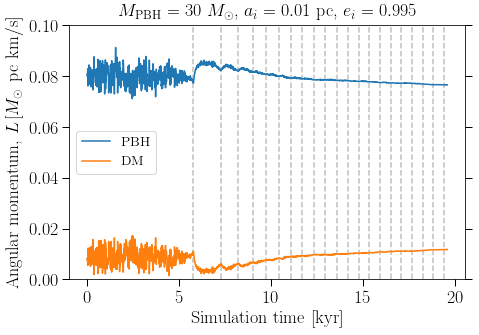

In [12]:
LPBH_mag = np.sqrt(np.sum(LPBH**2, 1))
LDM_mag = np.sqrt(np.sum(LDM**2, 1))

pl.figure(figsize=(7,5))

sep_cut = sep[550:]

t_cp_list = tvals[550:][np.r_[True, sep_cut[1:] < sep_cut[:-1]] & np.r_[sep_cut[:-1] < sep_cut[1:], True]]
print t_cp_list
#Calculate when the first close passage happens
#t_cp = tvals[np.argmin(sep[:600])]
#print(t_cp)
for t_cp in t_cp_list:
    pl.axvline(t_cp, linestyle='--', color='grey', alpha=0.5)
#pl.axvline(6.0, linestyle='--', color='grey', alpha=0.5)

pl.plot(tvals, LPBH_mag, label='PBH')
pl.plot(tvals, LDM_mag, label='DM')

pl.legend(loc='best', fontsize=14.0)
pl.title(title_text, fontsize=18.0)
pl.xlabel(r"Simulation time [kyr]")
pl.ylabel(r"Angular momentum, $L \,[M_\odot\,\,\mathrm{pc}\,\,\mathrm{km/s}]$")
pl.ylim(0, 0.1)
pl.tight_layout()
pl.savefig("../plots/PBH_L_" + simID + ".pdf", bbox_inches='tight')